# Import Packages

In [ ]:
!pip install pycm livelossplot
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch.optim as optim
from livelossplot import PlotLosses
from sklearn.metrics import mean_squared_error
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.8/601.8 kB 19.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Download and load data

In [ ]:
!curl "https://drive.usercontent.google.com/download?id={1Q4gn7Lq3sX1qVo05QpBr7nhBraJa9RXO}&confirm=xxx" -o "Ferguson_fire_train.zip"
!curl "https://drive.usercontent.google.com/download?id={1nDOD5WS46hv532U6T94RIP_BdHiiAl_Z}&confirm=xxx" -o "Ferguson_fire_test.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7610k  100 7610k    0     0   263k      0  0:00:28  0:00:28 --:--:-- 2106k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2926k  100 2926k    0     0  97970      0  0:00:30  0:00:30 --:--:--  671k


In [ ]:
import zipfile
with zipfile.ZipFile("./Ferguson_fire_train.zip", 'r') as z:
    z.extractall('./Ferguson_fire_train/')
with zipfile.ZipFile("./Ferguson_fire_test.zip", 'r') as z:
    z.extractall('./Ferguson_fire_test/')
print('Done.')

Done.


In [ ]:
train_data = np.load('Ferguson_fire_train/Ferguson_fire_train.npy')
test_data = np.load('Ferguson_fire_test/Ferguson_fire_test.npy')

In [ ]:
!curl "https://drive.usercontent.google.com/download?id={1lEBir-M3AmuI6mgAnms_t70PZHjBizP_}&confirm=xxx" -o "Ferguson_fire_background.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6295  100  6295    0     0  10355      0 --:--:-- --:--:-- --:--:-- 10370


In [ ]:
import zipfile
with zipfile.ZipFile("./Ferguson_fire_background.zip", 'r') as z:
    z.extractall('./Ferguson_fire_background/')
print('Done.')

Done.


In [ ]:
data_model = np.load('Ferguson_fire_background/Ferguson_fire_background.npy')

In [ ]:
!curl "https://drive.usercontent.google.com/download?id={1iC4lTWN-w5eSVbbC16WDa002AoFg4kQa}&confirm=xxx" -o "Ferguson_fire_obs.npy"
data_obs = np.load('Ferguson_fire_obs.npy')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2560k  100 2560k    0     0   478k      0  0:00:05  0:00:05 --:--:--  616k


# Define Dataset

## Define Helper functions

In [ ]:
def find_group(seq, step_size, start):
  group = []
  for i in range(seq):
    group.append(start + step_size*i)
  return group

def Input_target_Split(size, seq, step_size=10, period=100, target_length=4):
  '''
  size: 12500 input data size: 12500 for train; 5000 test
  e.g. return: [(0, 10, 20, 30) (10, 20, 30, 40)]; [(1, 11, 21, 31) (11, 21, 31, 41)], ....
  '''
  if seq * step_size >= 100:
    raise ValueError("Ensure seq times step_size less than period")
  period = 100
  num_chunk = size // period
  input = []
  target = []
  for i in range(num_chunk):
    chunk_input = []
    for j in range(i*period, (i+1)*period):
      group = find_group(seq, step_size, j)
      if group[-1] >= (i+1)*period:
        break
      chunk_input.append(group)
    input.extend(chunk_input[:-step_size])
    target.extend(chunk_input[step_size:])
  if target_length == 1:
    return input, [sublist[-1] for sublist in target]
  else:
    return input, target

In [ ]:
# input_indices, target_indices = Input_target_Split(size=12500, seq=4, step_size=10, period=100, target_length=1)
input_indices, target_indices = Input_target_Split(size=12500, seq=3, step_size=10, period=100, target_length=1)

## Define Dataset

In [ ]:
class CustomDataset(Dataset):
    '''
    oneD: if true, image is reshaped to 1d; has one dimension: 65536 or a
    dimension for seq length (see below)

    if target_indices is a single value; target data do not have dimesion: seq length
    if target_indices is a list; target data has a dimension: seq length
    '''

    def __init__(self, data, input_indices, target_indices, oneD=False):
        self.data = data
        self.input_indices = input_indices
        self.target_indices = target_indices
        self.oneD = oneD

    def __len__(self):
        return len(self.input_indices)

    def __getitem__(self, idx):
        input_idx = self.input_indices[idx]
        target_idx = self.target_indices[idx]

        # Retrieve the data points using the indices
        input_data = self.data[input_idx]
        target_data = self.data[target_idx]

        # Convert to tensors
        input_data = torch.tensor(input_data, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)

        if type(self.target_indices[0]) == int:
          input_data = input_data.unsqueeze(1)
          target_data = target_data.unsqueeze(0)
        elif type(self.target_indices[0]) == list:
          input_data = input_data.unsqueeze(1)
          target_data = target_data.unsqueeze(1)
        else:
          raise TypeError("Check the type of target data")


        if self.oneD:
            seq_length = len(self.input_indices[0])  # Adjust the sequence length accordingly
            image_width, image_height = input_data.shape[2], input_data.shape[3]
            input_data = input_data.view(seq_length, image_width * image_height)
            if type(self.target_indices[0]) == int:
              target_data = target_data.view(image_width * image_height)
            elif type(self.target_indices[0]) == list:
              target_data = target_data.view(seq_length, image_width * image_height)

        return input_data, target_data

## Define and Split Dataset

### Dataset: oneD, single target label

In [ ]:
train_dataset = CustomDataset(train_data, input_indices, target_indices, oneD=False)

In [ ]:
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

# Use random_split to split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [ ]:
# Create DataLoaders for the subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Define Model

## Flatten LSTM model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


### train the model

In [ ]:
# Parameters
input_dim = 65536  # Image width * Image height
hidden_dim = 1024
output_dim = 65536  # Adjust based on your specific problem
num_layers = 2
num_epochs = 20
learning_rate = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with validation
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (input_data, target_data) in enumerate(train_loader):
        input_data = input_data.to(device)
        target_data = target_data.to(device)

        # Forward pass
        outputs = model(input_data)
        loss = criterion(outputs, target_data)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_train_loss = train_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_data, target_data in val_loader:
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            outputs = model(input_data)
            loss = criterion(outputs, target_data)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

print("Training complete.")

Epoch [1/20], Step [10/188], Loss: 0.0268
Epoch [1/20], Step [20/188], Loss: 0.0138
Epoch [1/20], Step [30/188], Loss: 0.0173
Epoch [1/20], Step [40/188], Loss: 0.0175
Epoch [1/20], Step [50/188], Loss: 0.0156
Epoch [1/20], Step [60/188], Loss: 0.0132
Epoch [1/20], Step [70/188], Loss: 0.0125
Epoch [1/20], Step [80/188], Loss: 0.0106
Epoch [1/20], Step [90/188], Loss: 0.0143
Epoch [1/20], Step [100/188], Loss: 0.0108
Epoch [1/20], Step [110/188], Loss: 0.0125
Epoch [1/20], Step [120/188], Loss: 0.0105
Epoch [1/20], Step [130/188], Loss: 0.0100
Epoch [1/20], Step [140/188], Loss: 0.0134
Epoch [1/20], Step [150/188], Loss: 0.0088
Epoch [1/20], Step [160/188], Loss: 0.0106
Epoch [1/20], Step [170/188], Loss: 0.0093
Epoch [1/20], Step [180/188], Loss: 0.0083
Epoch [1/20], Average Training Loss: 0.0140, Average Validation Loss: 0.0102
Epoch [2/20], Step [10/188], Loss: 0.0097
Epoch [2/20], Step [20/188], Loss: 0.0091
Epoch [2/20], Step [30/188], Loss: 0.0107
Epoch [2/20], Step [40/188], Los

### Save the model if needed

In [ ]:
# Save the trained model
model_save_path = './gdrive/MyDrive/project3/path_to_save_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

### Load the model

If trained at above cell, then do not need to load

In [ ]:
# Parameters
input_dim = 65536  # Image width * Image height
hidden_dim = 1024
output_dim = 65536  # Adjust based on your specific problem
num_layers = 2
num_epochs = 20
learning_rate = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

In [ ]:
model_load_path = './gdrive/MyDrive/project3/path_to_save_model.pth'
model.load_state_dict(torch.load(model_load_path))
model.to(device)  # Move the model to the appropriate device
model.eval()  # Set the model to evaluation mode

print(f"Model loaded from {model_load_path}")

Model loaded from ./gdrive/MyDrive/project3/path_to_save_model.pth


## Convolutional layers LSTM

In [ ]:
class CustomDataset(Dataset):
    '''
    oneD: if true, image is reshaped to 1d; has one dimension: 65536 or a
    dimension for seq length (see below)

    if target_indices is a single value; target data do not have dimension: seq length
    if target_indices is a list; target data has a dimension: seq length
    '''

    def __init__(self, data, input_indices, target_indices, oneD=False):
        self.data = data
        self.input_indices = input_indices
        self.target_indices = target_indices
        self.oneD = oneD

    def __len__(self):
        return len(self.input_indices)

    def __getitem__(self, idx):
        input_idx = self.input_indices[idx]
        target_idx = self.target_indices[idx]

        # Retrieve the data points using the indices
        input_data = self.data[input_idx]
        target_data = self.data[target_idx]

        # Convert to tensors
        input_data = torch.tensor(input_data, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)

        if type(self.target_indices[0]) == int:
            input_data = input_data.unsqueeze(1)
            target_data = target_data.unsqueeze(0)
        elif type(self.target_indices[0]) == list:
            input_data = input_data.unsqueeze(1)
            target_data = target_data.unsqueeze(1)
        else:
            raise TypeError("Check the type of target data")

        if self.oneD:
            seq_length = len(self.input_indices[0])  # Adjust the sequence length accordingly
            image_width, image_height = input_data.shape[2], input_data.shape[3]
            input_data = input_data.view(seq_length, image_width * image_height)
            if type(self.target_indices[0]) == int:
                target_data = target_data.view(image_width * image_height)
            elif type(self.target_indices[0]) == list:
                target_data = target_data.view(seq_length, image_width * image_height)

        return input_data, target_data

class ConvLSTMModel(nn.Module):
    def __init__(self, hidden_dim, num_layers, seq_length, image_width, image_height):
        super(ConvLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.image_width = image_width
        self.image_height = image_height

        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size after convolutional layers
        self.conv_output_width = image_width // 8
        self.conv_output_height = image_height // 8
        self.conv_output_size = self.conv_output_width * self.conv_output_height * 64

        # LSTM layer
        self.lstm = nn.LSTM(self.conv_output_size, hidden_dim, num_layers, batch_first=True)

        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_dim, image_width * image_height)

    def forward(self, x):
        batch_size = x.size(0)

        # Apply convolutional layers to each image in the sequence
        conv_features = []
        for t in range(self.seq_length):
            conv_out = self.conv1(x[:, t])
            conv_out = torch.relu(conv_out)
            conv_out = self.pool(conv_out)

            conv_out = self.conv2(conv_out)
            conv_out = torch.relu(conv_out)
            conv_out = self.pool(conv_out)

            conv_out = self.conv3(conv_out)
            conv_out = torch.relu(conv_out)
            conv_out = self.pool(conv_out)

            conv_features.append(conv_out.view(batch_size, -1))

        conv_features = torch.stack(conv_features, dim=1)

        # Forward propagate LSTM
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        lstm_out, _ = self.lstm(conv_features, (h0, c0))

        # Get the output from the last time step
        lstm_out = lstm_out[:, -1, :]

        # Apply fully connected layer to get final output
        output = self.fc(lstm_out)
        output = output.view(batch_size, 1, self.image_width, self.image_height)

        return output

In [ ]:
# Example usage
# Assuming your data and indices are already loaded and defined
hidden_dim = 128
num_layers = 2
seq_length = 4  # Number of sequence steps
image_width = 256
image_height = 256

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the dataset with oneD=False
train_dataset = CustomDataset(train_data, input_indices, target_indices, oneD=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model = ConvLSTMModel(hidden_dim=hidden_dim, num_layers=num_layers, seq_length=seq_length, image_width=image_width, image_height=image_height).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    model.train()
    for input_data, target_data in train_loader:
        input_data, target_data = input_data.to(device), target_data.to(device)

        # Forward pass
        output = model(input_data)
        loss = criterion(output, target_data)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/20], Loss: {loss.item():.4f}')

print("Training complete.")

Epoch [1/20], Loss: 0.0084
Epoch [2/20], Loss: 0.0113
Epoch [3/20], Loss: 0.0116
Epoch [4/20], Loss: 0.0105
Epoch [5/20], Loss: 0.0076
Epoch [6/20], Loss: 0.0079
Epoch [7/20], Loss: 0.0098
Epoch [8/20], Loss: 0.0062
Epoch [9/20], Loss: 0.0094
Epoch [10/20], Loss: 0.0055
Epoch [11/20], Loss: 0.0071
Epoch [12/20], Loss: 0.0055
Epoch [13/20], Loss: 0.0061
Epoch [14/20], Loss: 0.0063
Epoch [15/20], Loss: 0.0045
Epoch [16/20], Loss: 0.0043
Epoch [17/20], Loss: 0.0032
Epoch [18/20], Loss: 0.0040
Epoch [19/20], Loss: 0.0040
Epoch [20/20], Loss: 0.0040
Training complete.


## Convolutional LSTM

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        if isinstance(kernel_size, tuple):
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)

        self.padding = (self.kernel_size[0] // 2, self.kernel_size[1] // 2)
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [ ]:
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        if not self.batch_first:
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
class ConvLSTMNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, image_size, batch_first=True):
        super(ConvLSTMNetwork, self).__init__()

        self.conv_lstm = ConvLSTM(input_dim=input_dim,
                                  hidden_dim=hidden_dim,
                                  kernel_size=kernel_size,
                                  num_layers=num_layers,
                                  batch_first=batch_first,
                                  return_all_layers=False)

        self.conv = nn.Conv2d(in_channels=hidden_dim[-1],
                              out_channels=1,
                              kernel_size=3,
                              padding=1)

    def forward(self, x):
        layer_output_list, last_state_list = self.conv_lstm(x)
        last_layer_output = layer_output_list[0]

        last_time_step = last_layer_output[:, -1, :, :, :]
        output = self.conv(last_time_step)
        output = torch.sigmoid(output)

        return output


In [ ]:
# Example usage
input_dim = 1
hidden_dim = [32, 32]  # Reduced number of filters
kernel_size = (3, 3)
num_layers = 2  # Reduced number of layers
image_size = (128, 128)  # Reduced image size
seq_length = 4
batch_size = 16  # Reduced batch size
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvLSTMNetwork(input_dim=input_dim,
                        hidden_dim=hidden_dim,
                        kernel_size=kernel_size,
                        num_layers=num_layers,
                        image_size=image_size,
                        batch_first=True).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming train_loader is defined and provides data in shape (batch_size, seq_length, channels, height, width)
for epoch in range(5):
    model.train()
    for input_data, target_data in train_loader:
        input_data, target_data = input_data.to(device), target_data.to(device)

        # Forward pass
        output = model(input_data)
        loss = criterion(output, target_data)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/20], Loss: {loss.item():.4f}')

print("Training complete.")

Epoch [1/20], Loss: 0.0116
Epoch [2/20], Loss: 0.0119
Epoch [3/20], Loss: 0.0083
Epoch [4/20], Loss: 0.0119
Epoch [5/20], Loss: 0.0123
Training complete.


# Display Images

## Display background/observation images

Mean Squared Error: 0.1083


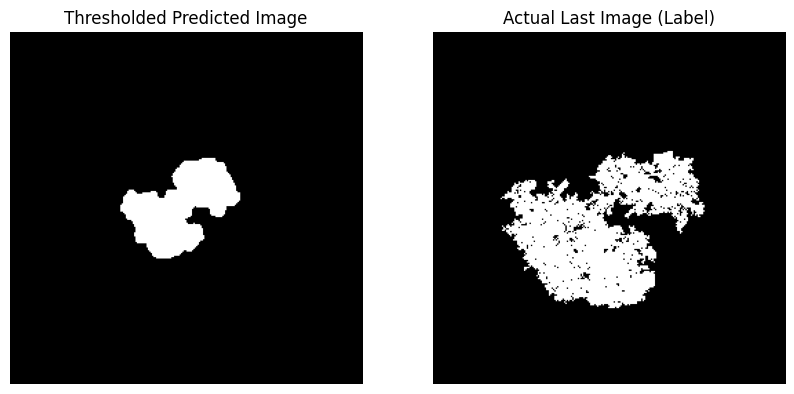

In [ ]:
def predict_and_display_5(data, model, device, threshold=0.5, dataidx=0, oneD=False):
    """
    Extracts the first four images from data_model, performs prediction using the model,
    applies thresholding, and displays the predicted and actual images.

    Parameters:
        data_model (np.array): The input data model containing the images.
        model (torch.nn.Module): The trained LSTM model.
        device (torch.device): The device to run the model on (CPU or GPU).
        threshold (float): The threshold value for binary classification.
        oneD (bool): Whether the input is 1D (True) or 3D with convolutional layers (False).
    """
    if oneD:
        # Extract the first four images
        # input_images = data[:4]
        input_images = data[:3]

        # Convert to tensor and add the required dimensions
        input_tensor = torch.tensor(input_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

        # Reshape to the required input shape for LSTM
        seq_length, image_width, image_height = input_tensor.shape[0], input_tensor.shape[2], input_tensor.shape[3]
        input_tensor = input_tensor.view(seq_length, image_width * image_height).unsqueeze(0)  # Add batch dimension
        print(input_tensor.shape)
    else:
        # For 3D input (with convolutional layers)
        # Extract the first four images
        # input_images = data[:4]
        # input_images = data[1:4]
        input_images = data[0].reshape(1, 256, 256)


        # Convert to tensor and add the required dimensions
        input_tensor = torch.tensor(input_images, dtype=torch.float32).unsqueeze(0).unsqueeze(2)  # Add batch dimension
        # print(input_tensor.shape)

    # Move model to device
    model.to(device)
    input_tensor = input_tensor.to(device)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predicted_output = model(input_tensor)

    # Reshape the output to the original image shape
    if oneD:
        predicted_image = predicted_output.view(image_width, image_height).cpu().numpy()
    else:
        predicted_image = predicted_output.squeeze(0).squeeze(0).cpu().numpy()

    # Calculate MSE
    mse = mean_squared_error(data[dataidx].flatten(), predicted_image.flatten())
    print(f"Mean Squared Error: {mse:.4f}")

    # Apply thresholding
    thresholded_image_np = np.where(predicted_image > threshold, 1, 0)

    # Display the thresholded predicted image and the actual last image
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(thresholded_image_np, cmap='gray')
    axs[0].set_title('Thresholded Predicted Image')
    axs[1].imshow(data[dataidx], cmap='gray')
    axs[1].set_title('Actual Last Image (Label)')

    # Remove axis for better visualization
    for ax in axs:
        ax.axis('off')

    plt.show()

# Example usage
# Assuming model, device, and data_model are already defined
# data_model = np.load('path_to_your_data_model.npy')  # Load your data model if needed

# For 1D input
# predict_and_display_5(data_model, model, device, oneD=True)

# For 3D input
predict_and_display_5(data_model, model, device, oneD=False)

Mean Squared Error: 0.0253


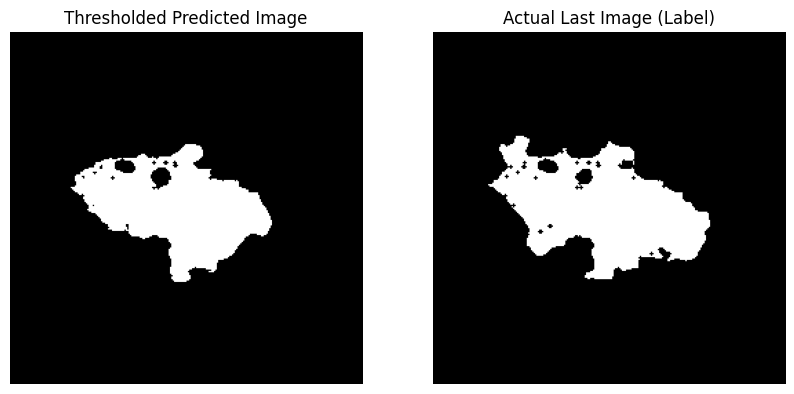

In [ ]:
predict_and_display_5(data_obs, model, device)

## Display random test set images

In [ ]:
test_input_indices, test_target_indices = Input_target_Split(size=5000, seq=4, step_size=10, period=100, target_length=1)

In [ ]:
# Assuming test_data is a numpy array of shape (N, 256, 256)
# and test_input_indices, test_target_indices are defined similarly to train indices
test_dataset = CustomDataset(test_data, test_input_indices, test_target_indices, oneD=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Using batch_size=1 for simplicity


Mean Squared Error: 0.0045


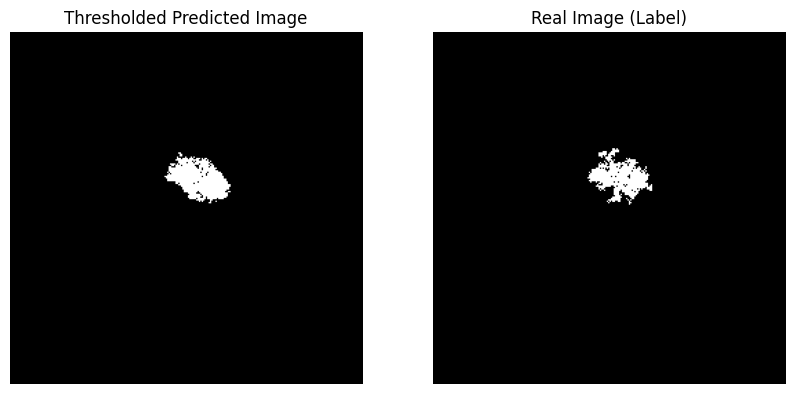

In [ ]:
import random
def predict_and_display_random(model, dataloader, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    # Randomly select an index
    random_index = random.randint(0, len(dataloader.dataset) - 1)

    with torch.no_grad():
        for i, (input_data, target_data) in enumerate(dataloader):
            if i == random_index:
                input_data = input_data.to(device)
                target_data = target_data.to(device)

                # Perform the prediction
                output = model(input_data)
                predicted_image = output.view(256, 256).cpu().numpy()

                mse = mean_squared_error(target_data.cpu().numpy().flatten(), predicted_image.flatten())
                print(f"Mean Squared Error: {mse:.4f}")

                # Apply thresholding
                thresholded_image = np.where(predicted_image > threshold, 1, 0)

                # Get the target image (label)
                real_image = target_data.view(256, 256).cpu().numpy()

                # Display the images
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                axs[0].imshow(thresholded_image, cmap='gray')
                axs[0].set_title('Thresholded Predicted Image')
                axs[1].imshow(real_image, cmap='gray')
                axs[1].set_title('Real Image (Label)')

                # Remove axis for better visualization
                for ax in axs:
                    ax.axis('off')

                plt.show()
                break

# Predict and display the results for a random data point in the test dataset
predict_and_display_random(model, test_loader)
